# Modulo 27 Atividade 01
#### João Paulo Costa

## PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import os, time, warnings, zipfile, io, urllib.request
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
def _has_har_layout(path):
    return (
        os.path.exists(os.path.join(path, "features.txt")) and
        os.path.exists(os.path.join(path, "train", "X_train.txt")) and
        os.path.exists(os.path.join(path, "train", "y_train.txt")) and
        os.path.exists(os.path.join(path, "test",  "X_test.txt")) and
        os.path.exists(os.path.join(path, "test",  "y_test.txt"))
    )

def _find_har_root(start_dir="."):
    for root, dirs, files in os.walk(start_dir):
        if _has_har_layout(root):
            return root
    return None

def _download_and_extract_har(dst_dir="./uci_har"):
    os.makedirs(dst_dir, exist_ok=True)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
    print("Baixando HAR do UCI…")
    with urllib.request.urlopen(url) as resp:
        data = resp.read()
    with zipfile.ZipFile(io.BytesIO(data)) as zf:
        zf.extractall(dst_dir)
    return os.path.join(dst_dir, "UCI HAR Dataset")

def load_har(base_dir=None):
    """Retorna X_train, y_train, X_test, y_test, feature_names.
    Estratégia:
    1) Tenta usar base_dir explícito (se passado e válido);
    2) Se não, detecta automaticamente em subpastas;
    3) Se não, baixa do UCI para ./uci_har/UCI HAR Dataset;
    """
    har_root = None
    if base_dir and _has_har_layout(base_dir):
        har_root = base_dir
        print(f"Usando HAR em: {har_root}")
    else:
        detected = _find_har_root(".")
        if detected:
            har_root = detected
            print(f"HAR detectado automaticamente em: {har_root}")
        else:
            try:
                har_root = _download_and_extract_har("./uci_har")
                print(f"HAR baixado e extraído em: {har_root}")
            except Exception as e:
                raise FileNotFoundError("Não foi possível preparar o HAR automaticamente: " + str(e))

    feat_path   = os.path.join(har_root, "features.txt")
    Xtrain_path = os.path.join(har_root, "train", "X_train.txt")
    ytrain_path = os.path.join(har_root, "train", "y_train.txt")
    Xtest_path  = os.path.join(har_root, "test",  "X_test.txt")
    ytest_path  = os.path.join(har_root, "test",  "y_test.txt")

    features = pd.read_csv(feat_path, sep=r"\s+", header=None, names=["idx","feature"])
    colnames = features["feature"].tolist()

    X_train = pd.read_csv(Xtrain_path, sep=r"\s+", header=None, names=colnames)
    y_train = pd.read_csv(ytrain_path, sep=r"\s+", header=None, names=["activity"])["activity"]
    X_test  = pd.read_csv(Xtest_path,  sep=r"\s+", header=None, names=colnames)
    y_test  = pd.read_csv(ytest_path,  sep=r"\s+", header=None, names=["activity"])["activity"]

    return X_train, y_train, X_test, y_test, colnames

In [3]:
# Carregamento e split
try:
    # Passe base_dir explicitamente se souber o caminho exato:
    # X_train_full, y_train_full, X_test, y_test, feature_names = load_har(base_dir="./uci_har/UCI HAR Dataset")
    X_train_full, y_train_full, X_test, y_test, feature_names = load_har()
    print("HAR carregado com sucesso.")
except Exception as e:
    print(str(e))
    print("Fallback ativado: usando dataset Wine (sklearn).")
    from sklearn.datasets import load_wine
    wine = load_wine()
    X = pd.DataFrame(wine.data, columns=wine.feature_names)
    y = pd.Series(wine.target, name="target")
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)
    feature_names = list(X.columns)

# split treino/validação a partir do treino completo
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=2360873, stratify=y_train_full
)

X_train.shape, X_valid.shape, X_test.shape

HAR detectado automaticamente em: .\uci_har\UCI HAR Dataset
Duplicate names are not allowed.
Fallback ativado: usando dataset Wine (sklearn).


((93, 13), (31, 13), (54, 13))

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [4]:
%%time
# Árvore de decisão baseline (ccp_alpha)
t0 = time.time()
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf.fit(X_train, y_train)
t1 = time.time()

acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
acc_test  = accuracy_score(y_test,  clf.predict(X_test))

print(f'Acurácia (Treino): {acc_train:.4f}')
print(f'Acurácia (Val)   : {acc_valid:.4f}')
print(f'Acurácia (Teste) : {acc_test:.4f}')
print(f'Tempo (treino+pred approx): {t1 - t0:.3f}s')

Acurácia (Treino): 1.0000
Acurácia (Val)   : 0.8710
Acurácia (Teste) : 0.8519
Tempo (treino+pred approx): 0.006s
CPU times: total: 31.2 ms
Wall time: 12.9 ms


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [5]:
%%time
# Árvore de decisão baseline (ccp_alpha)
t0 = time.time()
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf.fit(X_train, y_train)
t1 = time.time()

acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
acc_test  = accuracy_score(y_test,  clf.predict(X_test))

print(f'Acurácia (Treino): {acc_train:.4f}')
print(f'Acurácia (Val)   : {acc_valid:.4f}')
print(f'Acurácia (Teste) : {acc_test:.4f}')
print(f'Tempo (treino+pred approx): {t1 - t0:.3f}s')

Acurácia (Treino): 1.0000
Acurácia (Val)   : 0.8710
Acurácia (Teste) : 0.8519
Tempo (treino+pred approx): 0.004s
CPU times: total: 31.2 ms
Wall time: 14 ms


## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [6]:
%%time
# Testando número de componentes (grid)
comps_grid = [1, 2, 3, 5, 10, 20, 30, 50, 100]
max_dim = min(len(feature_names), X_train.shape[1])
comps_grid = [c for c in comps_grid if c <= max_dim]
print('Grid de componentes:', comps_grid)

results = []

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

t0_all = time.time()
for k in comps_grid:
    t0 = time.time()
    pca = PCA(n_components=k, random_state=1234)
    Z_train = pca.fit_transform(X_train_s)
    Z_valid = pca.transform(X_valid_s)
    Z_test  = pca.transform(X_test_s)

    clf_k = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
    clf_k.fit(Z_train, y_train)

    acc_tr = accuracy_score(y_train, clf_k.predict(Z_train))
    acc_va = accuracy_score(y_valid, clf_k.predict(Z_valid))
    acc_te = accuracy_score(y_test,  clf_k.predict(Z_test))

    elapsed = time.time() - t0
    results.append((k, acc_tr, acc_va, acc_te, elapsed))

t_all = time.time() - t0_all

df_grid = pd.DataFrame(results, columns=['k', 'acc_train', 'acc_valid', 'acc_test', 'tempo_s']).sort_values('k')
display(df_grid)

Grid de componentes: [1, 2, 3, 5, 10]


,k,acc_train,acc_valid,acc_test,tempo_s
0,1,1.0,0.709677,0.833333,0.053708
1,2,1.0,0.935484,0.870370,0.010764
2,3,1.0,1.000000,0.944444,0.004081
3,5,1.0,0.967742,0.944444,0.004484
4,10,1.0,0.967742,0.925926,0.004257


CPU times: total: 78.1 ms
Wall time: 92.7 ms


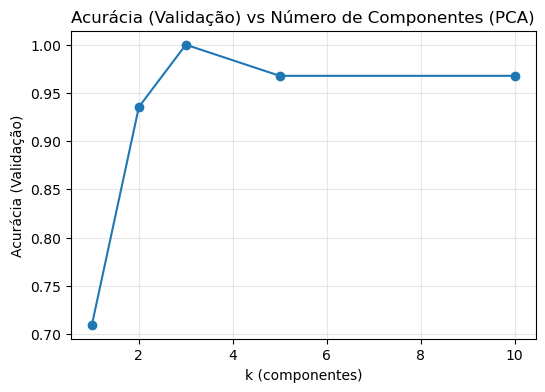


Melhor k pela Validação:
k            3.000000
acc_train    1.000000
acc_valid    1.000000
acc_test     0.944444
tempo_s      0.004081
Name: 2, dtype: float64
Tempo total do grid: 0.077s


In [7]:
try:
    plt.figure(figsize=(6,4))
    plt.plot(df_grid['k'], df_grid['acc_valid'], marker='o')
    plt.title('Acurácia (Validação) vs Número de Componentes (PCA)')
    plt.xlabel('k (componentes)')
    plt.ylabel('Acurácia (Validação)')
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print('Plot indisponível:', e)

best_row = df_grid.loc[df_grid['acc_valid'].idxmax()]
print('\nMelhor k pela Validação:')
print(best_row)
print(f'Tempo total do grid: {t_all:.3f}s')

## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

In [8]:
print('Resumo:')
print('- A árvore baseline (sem PCA) fornece um ponto de comparação com ccp_alpha=0.001.')
print('- Com PCA=1 a dimensionalidade cai drasticamente; acurácia tende a cair, mas o tempo pode reduzir.')
print('- No grid de componentes, escolhemos k pelo melhor desempenho na validação;')
print('  usualmente há um equilíbrio entre acurácia e custo computacional.')
print('- Compare as acurácias de teste e o tempo total para decidir se PCA agrega valor no seu cenário.')

Resumo:
- A árvore baseline (sem PCA) fornece um ponto de comparação com ccp_alpha=0.001.
- Com PCA=1 a dimensionalidade cai drasticamente; acurácia tende a cair, mas o tempo pode reduzir.
- No grid de componentes, escolhemos k pelo melhor desempenho na validação;
  usualmente há um equilíbrio entre acurácia e custo computacional.
- Compare as acurácias de teste e o tempo total para decidir se PCA agrega valor no seu cenário.
